In [65]:
from sklearn import linear_model
import pandas as pd
import numpy as np
from datetime import timedelta
import dash_core_components as dcc
import dash_daq as daq
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
import dash_table
import dash
import plotly.express as px
from flask import Flask

def predict_next_fail(n, T, beta):
    lamb = n / (T**beta)
    lamb_hat = lamb * beta * T ** (beta-1)
    TTF = 1 / lamb_hat
    return TTF

def make_crow_data(site_val = 'CHB', 
                 fail_type='All'):
    site = sites.loc[sites['Plant'].str.contains(site_val)]
    site = site.reset_index(drop=True)
    if fail_type == 'All':
        pass
    else:
        site = site.loc[site['Equipment/Process'] == fail_type].reset_index()
    result = wrap_calc_beta(site)
    return result

def make_scatter(result, y, log=False):
    fig = px.scatter(result, x='Cumulative Days', y=y, color='Equipment/Process', size='Klbs',
                    log_x=log, log_y=log)
    fig.update_layout(
                    height= 400)
    return fig

def calc_beta(n, T, cumTTF):
    return n / (n * np.log(T) - np.sum(np.log(cumTTF[:n])))

def find_peaks(result):
    # find peaks, 4-padded
    betas = result['Beta'].values[1:]
    peaks = np.zeros(len(betas)+1)
    peaks[5:-4][((betas[4:-4] - betas[3:-5] > 0) & 
     (betas[4:-4] - betas[2:-6] > 0) &
     (betas[4:-4] - betas[1:-7] > 0) &
     (betas[4:-4] - betas[0:-8] > 0) &
     (betas[4:-4] - betas[5:-3] > 0) & 
     (betas[4:-4] - betas[6:-2] > 0) &
     (betas[4:-4] - betas[7:-1] > 0) &
     (betas[4:-4] - betas[8:] > 0)) |
    ((betas[4:-4] - betas[3:-5] < 0) & 
     (betas[4:-4] - betas[2:-6] < 0) &
     (betas[4:-4] - betas[1:-7] < 0) &
     (betas[4:-4] - betas[0:-8] < 0) &
     (betas[4:-4] - betas[5:-3] < 0) & 
     (betas[4:-4] - betas[6:-2] < 0) &
     (betas[4:-4] - betas[7:-1] < 0) &
     (betas[4:-4] - betas[8:] < 0)) ] = 1
    peaks = np.argwhere(peaks).flatten()
    return peaks

### NEW ###

def make_scatter_with_regr(result, peaks, x_label='Cumulative Days'):
    x_label = 'Date'
    # plot len(peaks) + 1 linear models
    log = False
    fig = px.scatter(result, x=x_label, y='Failure Number', color='Peak', size='Loss',
                        log_x=log, log_y=log)
    fig.update_layout(
                    height= 400)

    for i in range(len(peaks)+1):
        # define range, fit model

        model = linear_model.LinearRegression()
        if i == 0: # first seg
            segment = peaks[i]
            x = result.iloc[0:segment]['Cumulative Days'].values
            x_date = result.iloc[0:segment]['Date'].values
            y = result.iloc[0:segment]['Failure Number'].values
        elif i == len(peaks): # last seg
            segment = peaks[i-1]
            x = result.iloc[segment:]['Cumulative Days'].values
            x_date = result.iloc[segment:]['Date'].values
            y = result.iloc[segment:]['Failure Number'].values
        else: # middle segs
            segment = peaks[i]
            x = result.iloc[old_segment:segment]['Cumulative Days'].values
            x_date = result.iloc[old_segment:segment]['Date'].values
            y = result.iloc[old_segment:segment]['Failure Number'].values
        model.fit(x.reshape(-1,1),y)

        # grab coefs, make line
        m = model.coef_[0]
        b = model.intercept_
        regrx = np.linspace(x[0], x[-1])
        regry = regrx*m+b
        if x_label == 'Date':
            x_lines = [x_date[0], x_date[-1]]
        else:
            x_lines = [x[0], x[-1]]

        old_segment = segment
        fig.add_trace(go.Scatter(x=x_lines, y=[regry[0], regry[-1]],
                        mode='lines',
                        name=f'slope: {m:.3f}',
                            ))
    return fig

def wrap_calc_beta(site):
    beta = []
    T0 = site.loc[0, 'Date'] 
    cumTTF = []
    failN = []
    deltT0 = site.loc[0, 'Cum Days']
    ind = 0
    for n, T in enumerate(site['Date']):
        cumTTF.append((T-T0).days+deltT0)
        failN.append(n+1)
        if ind == 0:
            beta.append(np.nan)
        else:
            beta.append(calc_beta(n, (T-T0).days+deltT0, cumTTF))
        ind += 1
    if 'Equipment/Process' in site.columns:
        result = site[['Date', 'Equipment/Process', 
                       'Failure Mode', 'Contributing Factor', 'Klbs']].join(
                        pd.DataFrame.from_dict(({'Beta': np.round(beta,3), 
                        'Cumulative Days': cumTTF, 'Failure Number': failN})))
        result.Klbs = result.Klbs.round(2)
    else:
        result = site[['Date', 'Loss']].join(
                        pd.DataFrame.from_dict(({'Beta': np.round(beta,3), 
                        'Cumulative Days': cumTTF, 'Failure Number': failN})))
    
    result = result.fillna(value='None')
    return result

def update_plot(site, reason):
    result = make_crow_data(site, reason)
    TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                        ['Failure Number', 'Cumulative Days', 'Beta']].values)
    next_fail = result.iloc[-1,0] + timedelta(days=TTF)
    result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
    return [make_scatter(result, 'Beta', False),
            make_scatter(result, 'Failure Number', False),
           result.to_dict('records'),
           f"Next Failure: {next_fail.date()}"]

In [2]:
# Load Data, Init Variables
sites = pd.read_csv("../crowamsaa_data.csv", parse_dates=['Date'])
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
site_vals = ['CHB', 'DEC', 'PEN']
fail_types = ['Equipment', 'Process', 'Equipment (Design)', 'All']

result = make_crow_data('CHB', 'All')
TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                        ['Failure Number', 'Cumulative Days', 'Beta']].values)
next_fail = result.iloc[-1,0] + timedelta(days=TTF)
result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
peaks = find_peaks(result)
result['Peak'] = False
result.iloc[peaks, -1] = True

In [3]:
# Import Data
df = pd.read_excel('../data/20211229 Sal Acid Daily Production including OEE.xlsm', 
                   sheet_name='Special Causes (2)', 
                   engine='openpyxl')

# Process Data
events = df[['Special Cause Event Start Date', 'Special Cause Event Production Loss\n[Tons]']]
events = events.dropna()
events = events.reset_index(drop=True)
events.columns = ['Date', 'Loss']
events['Cum Days'] = events['Date'] - events['Date'][0]
events['Cum Days'] = events['Cum Days'].dt.days
events = events.iloc[1:]
events = events.reset_index(drop=True)
# events.iloc[0,2] = 1

# Crow-AMSAA
result = wrap_calc_beta(events)
TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                        ['Failure Number', 'Cumulative Days', 'Beta']].values)
next_fail = result.iloc[-1,0] + timedelta(days=TTF)
result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
peaks = find_peaks(result)
result['Peak'] = False
result.iloc[peaks, -1] = True

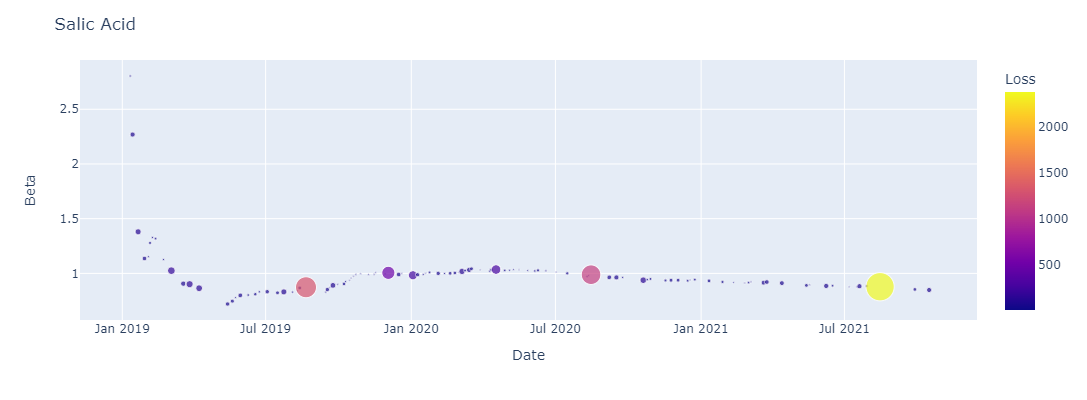

In [7]:
log = False
fig = px.scatter(result, x='Date', y='Beta', color='Loss', size='Loss',
                    log_x=log, log_y=log)
fig.update_layout(
                height= 400,
                title='Salic Acid')
fig.write_image('../assets/salic_acid_1.svg')
fig.show()

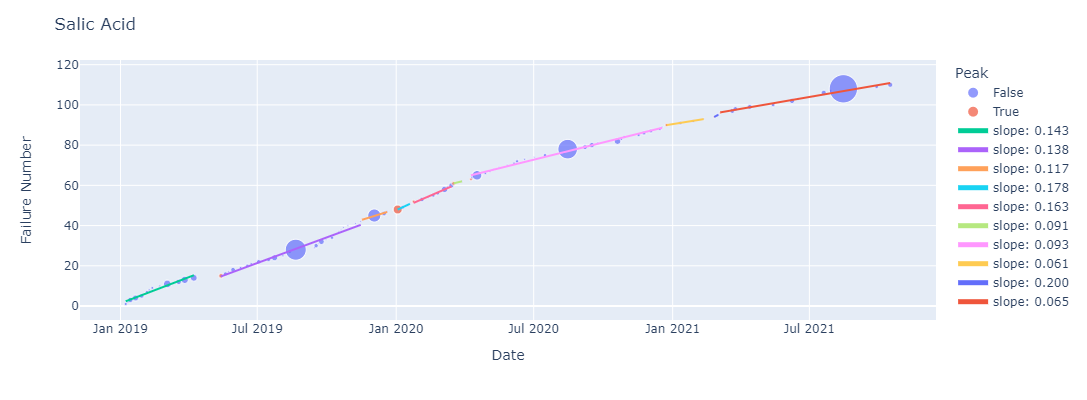

In [6]:
fig = make_scatter_with_regr(result, peaks, x_label='Date')
fig.update_layout(title = 'Salic Acid')
fig.write_image('../assets/salic_acid_2.svg')
fig.show()

In [86]:
# Import Data
df = pd.read_excel('../data/Phenol production data with dist to purif correction.xlsx', 
                   sheet_name='Special Causes', 
                   header=[0,1],
                   engine='openpyxl')

In [87]:
df.columns.levels[0]

Index(['Phenol to Storage', 'Train 3 Distillation to Purification',
       'Train 3 HPOC to Cleavage', 'Train 4 Distillation to Purification',
       'Train 4 HPOC to Cleavage'],
      dtype='object')

In [88]:
# Import Data
df2 = pd.read_excel('../data/Phenol production data with dist to purif correction.xlsx', 
                   sheet_name='HPOC Special Cause', 
                   header=[0,1],
                   engine='openpyxl')

In [93]:
### TURN AROUNDS
if 'Train 3' in title:
    hpoc = 'Train 3 HPOC'
    x_ta = df2.loc[df2[hpoc]['Category'] == 'TA'][hpoc]['Start Date'].values
elif 'Train 4' in title:
    hpoc = 'Train 4 HPOC'
    x_ta = df2.loc[df2[hpoc]['Category'] == 'TA'][hpoc]['Start Date'].values
else:
    x_ta1 = df2.loc[df2[hpoc]['Category'] == 'TA'][hpoc]['Start Date'].values
    x_ta2 = df2.loc[df2['Train 4 HPOC']['Category'] == 'TA'][hpoc]['Start Date'].values
    x_ta = np.vstack([x_ta1, x_ta2]).flatten()
x_ta = np.repeat(x_ta, 2)
x_ta = x_ta.reshape(-1,2)

y2 = max(fig2.data[0]['y'])
y1 = min(fig2.data[0]['y'])
y_ta = [y1, y2]
y_ta = np.tile(y_ta, x_ta.shape[0])
y_ta = y_ta.reshape(-1, 2)

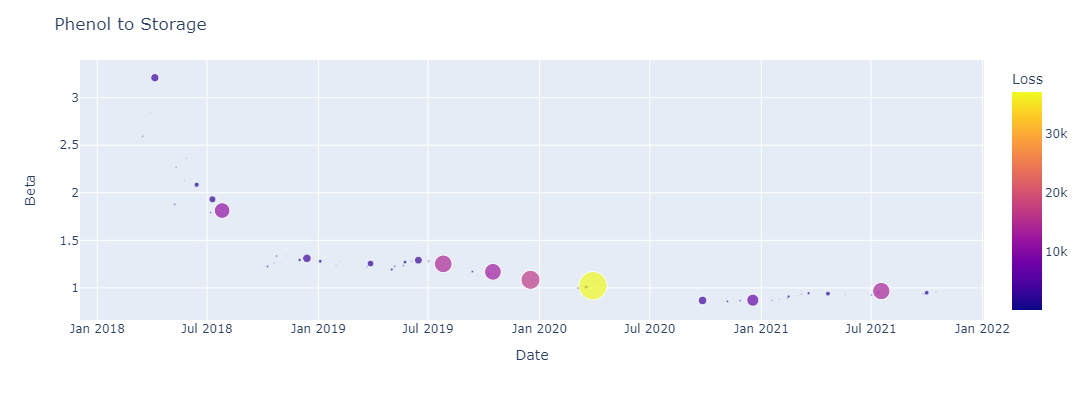

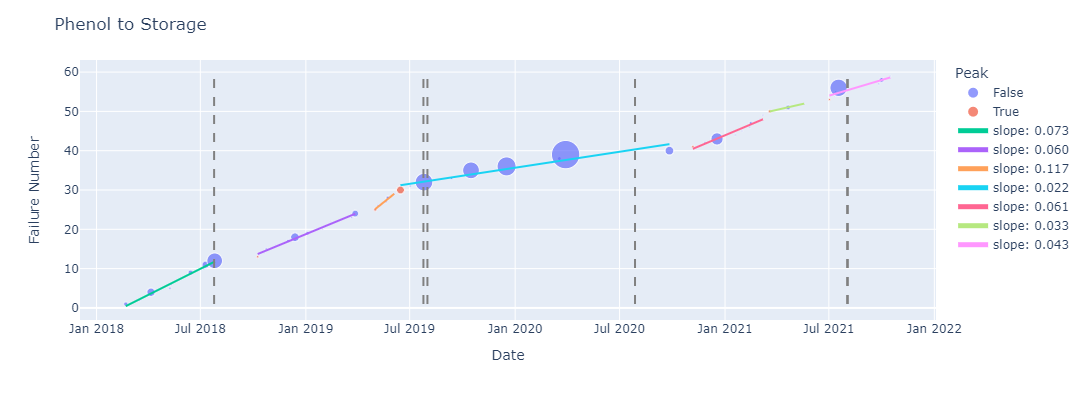

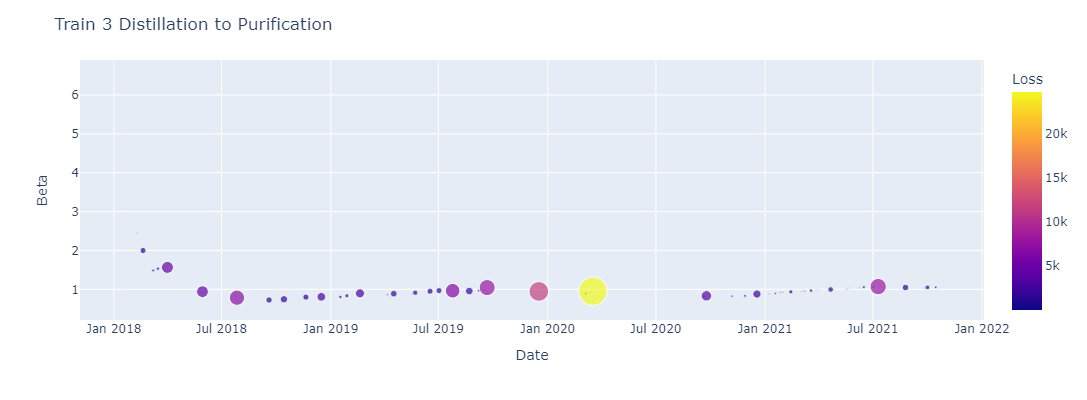

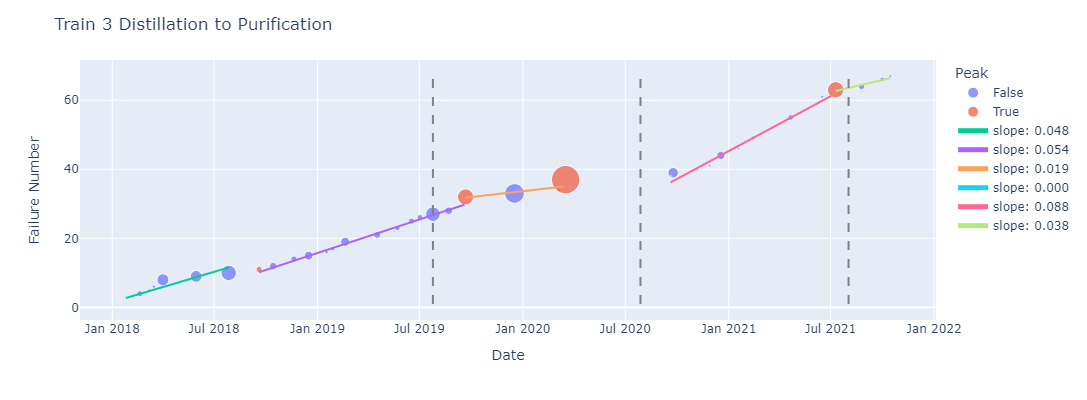

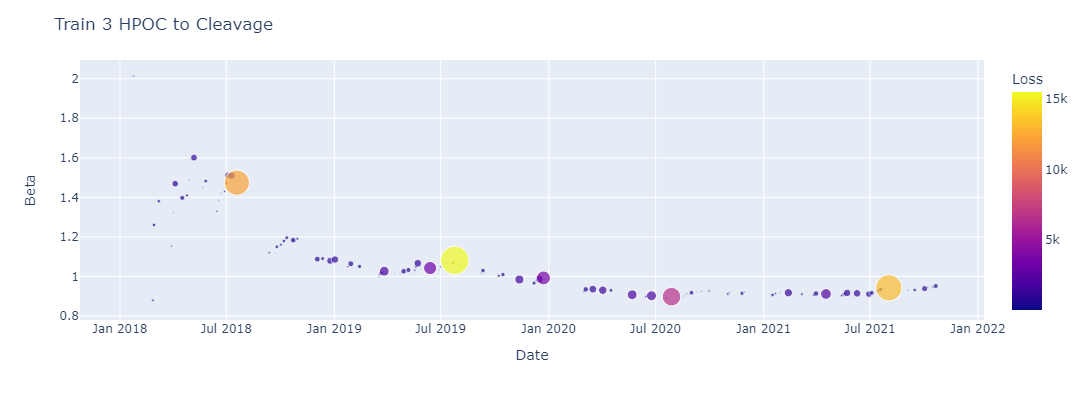

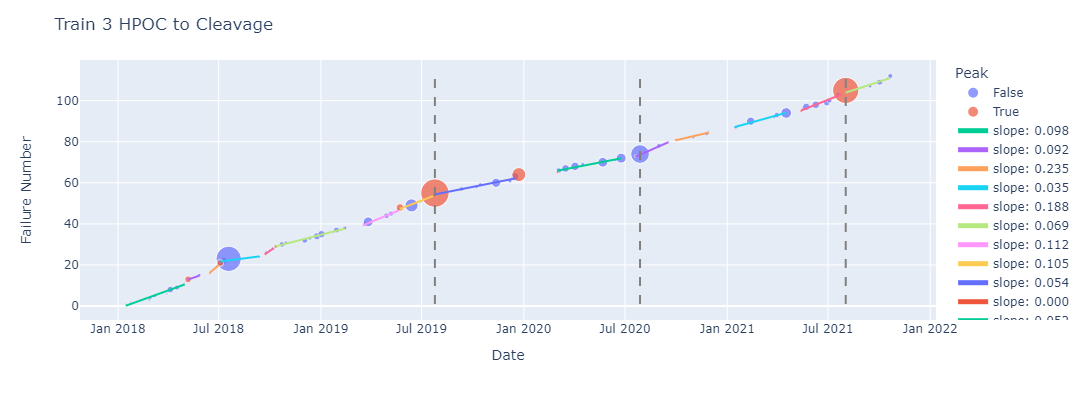

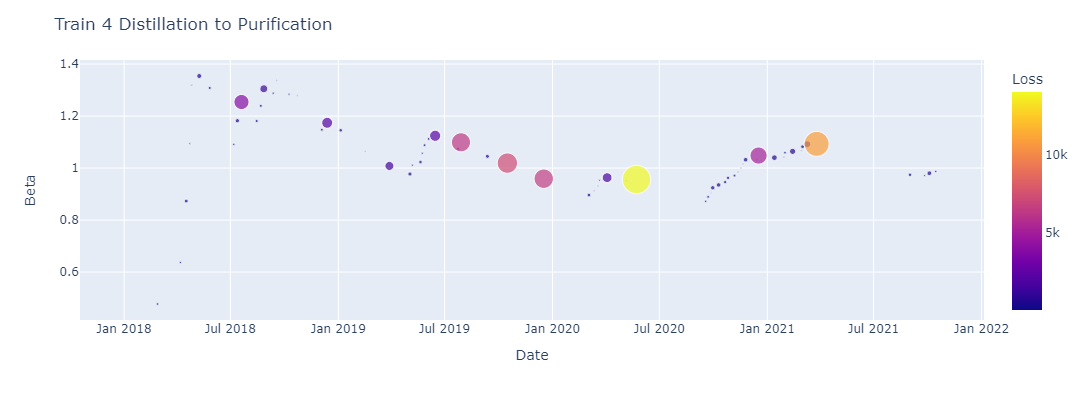

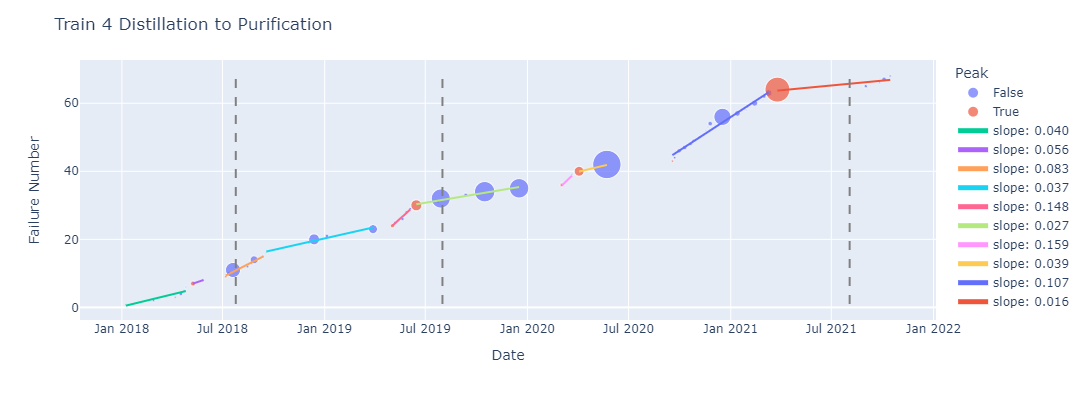

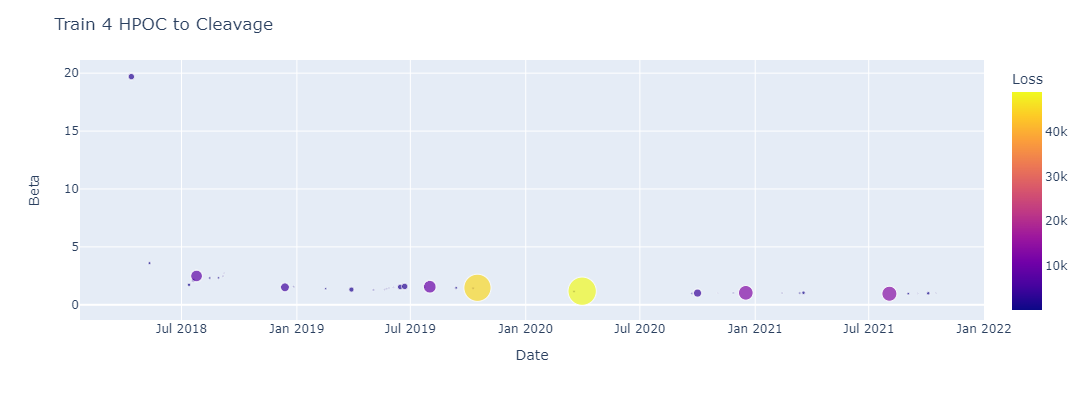

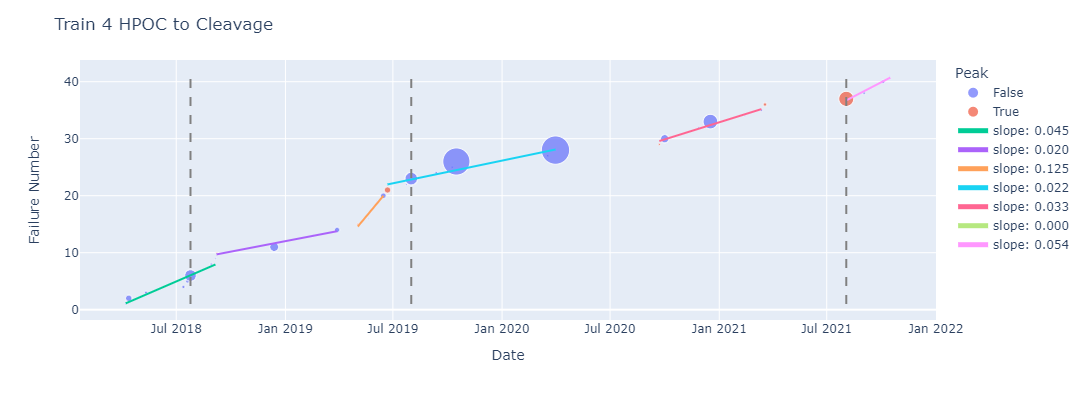

In [122]:
# Process Data
for title in df.columns.levels[0]:
    
    ### EVENT DATA CLEANING
    events = df[title][['Special Cause Event Start Date', 'Special Cause Event Production Loss\n[Tons]']]
    events = events.dropna()
    events = events.reset_index(drop=True)
    events.columns = ['Date', 'Loss']
    events['Cum Days'] = events['Date'] - events['Date'][0]
    events['Cum Days'] = events['Cum Days'].dt.days
    events = events.iloc[1:]
    events = events.reset_index(drop=True)
    # events.iloc[0,2] = 1

    ### Crow-AMSAA
    result = None
    result = wrap_calc_beta(events)
    TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                            ['Failure Number', 'Cumulative Days', 'Beta']].values)
    next_fail = result.iloc[-1,0] + timedelta(days=TTF)
    result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
    peaks = find_peaks(result)
    result['Peak'] = False
    result.iloc[peaks, -1] = True

    ### BUILD PLOTS
    log = False
    fig = px.scatter(result, x='Date', y='Beta', color='Loss', size='Loss',
                        log_x=log, log_y=log)
    fig.update_layout(
                    height= 400)
    fig.update_layout({'title': title})
    fig.write_image(f'../assets/{title}1.svg')
    fig.show()

    fig2 = make_scatter_with_regr(result, peaks)
    # train 3 HPOC to cleavage
    # phenol to storage
    fig2.update_layout({'title': title})
    
    ### TURN AROUNDS
    if 'Train 3' in title:
        hpoc = 'Train 3 HPOC'
        x_ta = df2.loc[df2[hpoc]['Category'] == 'TA'][hpoc]['Start Date'].values
    elif 'Train 4' in title:
        hpoc = 'Train 4 HPOC'
        x_ta = df2.loc[df2[hpoc]['Category'] == 'TA'][hpoc]['Start Date'].values
    else:
        
        x_ta1 = df2.loc[df2['Train 3 HPOC']['Category'] == 'TA']['Train 3 HPOC']['Start Date'].values
        x_ta2 = df2.loc[df2['Train 4 HPOC']['Category'] == 'TA']['Train 4 HPOC']['Start Date'].values
        x_ta = np.vstack([x_ta1, x_ta2]).flatten()
    x_ta = np.repeat(x_ta, 2)
    x_ta = x_ta.reshape(-1,2)

    y2 = max(fig2.data[0]['y'])
    y1 = min(fig2.data[0]['y'])
    y_ta = [y1, y2]
    y_ta = np.tile(y_ta, x_ta.shape[0])
    y_ta = y_ta.reshape(-1, 2)
    
    for i in range(x_ta.shape[0]):
        fig2.add_trace(go.Scatter(x=x_ta[i], y=y_ta[i],
                                mode='lines',
                                  line=dict(color='grey',
                                  dash='dash'),
                                name='turn around',
                                  showlegend=False
                                    ))
    fig2.write_image(f'../assets/{title}2.svg')
    fig2.show()
    